In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../funcs/')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax

In [3]:
DATA_DIR = "../data/raw/proteomics/"
OUT_DIR = "../data/processed/061721_genecentric"
PLOTS_DIR = "figures/data_processing_genecentric"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"
SUBSET_LOCALIZED_SITES = True
KNN_NEIGHBORS = 5

In [4]:
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

os.makedirs(os.path.join(OUT_DIR, "raw"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "nafilt"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "imputed_res"), exist_ok=True)

## 1. Loading Info from Raw `.gct` Files

`accessionNumber_VMsites_numVMsitesPresent_numVMsitesLocalizedBest_earliestVMsiteAA_latestVMsiteAA`

---

In [123]:
# PTM

# g = prot.GCT("../data/raw/proteomics/BRCA/hg38-brca-phosphoproteome-ratio-median-norm_V3.02.51.gct")

# _prev = g.n_var
# feats_to_keep = g.var_names[[x.split("_")[3]==x.split("_")[4] for x in g.var_names]]
# g.subset(var=feats_to_keep)
# print("     * {} | {}/{} ({:,.2f}%) fully localized sites".format(g.assay, g.n_var, _prev, 100*g.n_var/_prev))

# _var = g.var.copy()
# _var = _var[['id.1','id.description','geneSymbol','variableSites','protein_group_num']]

In [158]:
gct["LUAD"]["proteome"].filename

'hg38-ucec-proteome-ratio-median-norm_V2.02.00.gct'

In [159]:
gct = {}

for x in glob.glob(os.path.join(DATA_DIR,'*')):
    if os.path.isdir(x):
        cohort = os.path.basename(x).upper()
        cohort_gct = {}
        print("   * Loading {} ...".format(cohort))
        
        for filepath in glob.glob(os.path.join(x,"*.gct")):
            if '-proteome-' in os.path.basename(filepath):
                g = prot.GCT(filepath)
                prot.collapse_prot_to_gene(g)
            else:
                pass
                if SUBSET_LOCALIZED_SITES:
                    if g.assay in ('acetylome','phosphoproteome'):
                        _prev = g.n_var
                        feats_to_keep = g.var_names[[x.split("_")[3]==x.split("_")[4] for x in g.var_names]]
                        g.subset(var=feats_to_keep)
                        print("     * {} | {}/{} ({:,.2f}%) fully localized sites".format(g.assay, g.n_var, _prev, 100*g.n_var/_prev))

            cohort_gct[g.assay] = g
 
        gct[cohort] = cohort_gct

   * Loading COAD ...
      * 314 / 8922 protein rows filtered
   * Loading MEDUL ...
      * 1006 / 12909 protein rows filtered
   * Loading UCEC ...
      * 862 / 13000 protein rows filtered
   * Loading LUAD ...
      * 1044 / 14045 protein rows filtered
   * Loading HNSCC ...
      * 814 / 13081 protein rows filtered
   * Loading PDAC ...
      * 645 / 12214 protein rows filtered
   * Loading CCRCC ...
      * 715 / 12434 protein rows filtered
   * Loading BRCA ...
      * 1004 / 13248 protein rows filtered
   * Loading GBM ...
      * 1059 / 13343 protein rows filtered
   * Loading OV ...
      * 514 / 11285 protein rows filtered
   * Loading LSCC ...
      * 1065 / 14129 protein rows filtered


In [160]:
prot.parse_participant_and_type(gct,'proteome')
#prot.parse_participant_and_type(gct,'phosphoproteome')
#prot.parse_participant_and_type(gct,'acetylome')

In [161]:
prot_df = pd.concat([gct[cohort]['proteome'].obs for cohort in gct.keys()])
#phosph_df = pd.concat([gct[cohort]['phosphoproteome'].obs for cohort in gct.keys()])
#acetyl_df = pd.concat([gct[cohort]['acetylome'].obs for cohort in ['BRCA','GBM','LSCC','LUAD','UCEC','MEDUL']])

In [162]:
prot_feat_count = prot.compile_feature_counts(gct, 'proteome')
#phosph_feat_count = prot.compile_feature_counts(gct, 'phosphoproteome')
#acetyl_feat_count = prot.compile_feature_counts(gct, 'acetylome')

In [163]:
prot_feat_count.to_csv(os.path.join(DATA_DIR, "proteome_feat_counts.tsv"), sep='\t')
#phosph_feat_count.to_csv(os.path.join(DATA_DIR, "phosphoproteome_feat_counts.tsv"), sep='\t')
#acetyl_feat_count.to_csv(os.path.join(DATA_DIR, "acetylome_feat_counts.tsv"), sep='\t')

## 2. Load Participant Dataframe


Curated by Yo Akiyama.

---

In [167]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)
samples_df.head()

,cohort,Proteome_Sample_ID,Proteome_Normal_Sample_ID,Phosphoproteome_Sample_ID,Phosphoproteome_Normal_Sample_ID,Acetylome_Sample_ID,Acetylome_Normal_Sample_ID,RNA_Tumor,RNA_Normal,Germline_WGS,WXS
participant_id,,,,,,,,,,,
CPT000814,BRCA,CPT000814,NaN,CPT000814,NaN,CPT000814,NaN,334_R,NaN,NaN,604_T
CPT001846,BRCA,CPT001846,NaN,CPT001846,NaN,CPT001846,NaN,340_R,NaN,NaN,01BR044_T
01BR001,BRCA,X01BR001,NaN,X01BR001,NaN,X01BR001,NaN,25-R,NaN,NaN,01BR001_T
01BR008,BRCA,X01BR008,NaN,X01BR008,NaN,X01BR008,NaN,350-R,NaN,NaN,01BR008_T
01BR009,BRCA,X01BR009,NaN,X01BR009,NaN,X01BR009,NaN,345-R,NaN,NaN,01BR009_T


In [168]:
prot_df.to_csv(os.path.join(OUT_DIR, "proteome_obs.tsv"),sep='\t')
#phosph_df.to_csv(os.path.join(OUT_DIR, "phosphoproteome_obs.tsv"),sep='\t')
#acetyl_df.to_csv(os.path.join(OUT_DIR, "acetylome_obs.tsv"),sep='\t')

## 3. Save Protein Variable Metadata
---

In [169]:
prot_pmap_df = pd.concat([gct[cohort]['proteome'].var for cohort in gct.keys()]).loc[:,[
    'id.description',
    'geneSymbol',
    'protein_mw',
    'accession_number',
    'feature'  
]]

prot_pmap_df['protein_mw'] = prot_pmap_df['protein_mw'].astype(float)
prot_pmap_df = prot_pmap_df.drop_duplicates()

In [170]:
# phosph_pmap_df = pd.concat([gct[cohort]['phosphoproteome'].var for cohort in gct.keys()]).loc[:,[
#     'id.description',
#     'geneSymbol',
#     'variableSites',
#     'sequence',
#     'VMsiteFlanks',
#     'sequenceVML',
#     'protein_mw',
#     'accession_number',
#     'feature'
# ]]
# phosph_pmap_df = prot.process_ptm_var(phosph_pmap_df)

In [171]:
# acetyl_pmap_df = pd.concat([gct[cohort]['acetylome'].var for cohort in ['BRCA','GBM','LSCC','LUAD','UCEC','MEDUL']]).loc[:,[
#     'id.description',
#     'geneSymbol',
#     'variableSites',
#     'sequence',
#     'VMsiteFlanks',
#     'sequenceVML',
#     'protein_mw',
#     'accession_number',
#     'feature'
# ]]
# acetyl_pmap_df = prot.process_ptm_var(acetyl_pmap_df)

In [172]:
pmap_df = pd.concat((
    prot_pmap_df,
    #phosph_pmap_df,
    #acetyl_pmap_df
))

In [174]:
pmap_df.to_csv(os.path.join(OUT_DIR, "var_map.tsv"),sep='\t')

In [175]:
# pmap_df[pmap_df['feature']=='phosphoproteome'][['geneSymbol','accession_number','sequence','sequenceVML','VMsiteFlanks','variableSites',]].to_csv(
#     os.path.join(OUT_DIR, "phospho_site_flanks.tsv"), sep='\t'
# )

## 4. Combine Matrices
---

In [179]:
def get_samples(samples_df, cohort, col):
    return samples_df[samples_df['cohort']==cohort][col].dropna()

In [180]:
assays = ('proteome',)

raw_data_files = {}
n_feats = {}
features_df = list()

for assay in assays:
    raw_data_files[assay] = {}
    n_feats[assay] = {}
    
    for cohort in gct.keys():
        if assay in gct[cohort]:
            raw_data_files[assay][cohort] = {}
            
            # Tumor
            raw_data_files[assay][cohort]['Tumor'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # Normal
            raw_data_files[assay][cohort]['Normal'] = gct[cohort][assay].X[
                get_samples(samples_df, cohort, '{}_Normal_Sample_ID'.format(assay.capitalize()))
            ].dropna(axis=0,how='all').copy()
            
            # Stats
            n_feats[assay][cohort] = {}
            n_feats[assay][cohort]['Tumor'] = {}
            n_feats[assay][cohort]['Normal'] = {}

            n_feats[assay][cohort]['Tumor']['coverage'] = raw_data_files[assay][cohort]['Tumor'].shape[0]
            n_feats[assay][cohort]['Tumor']['samples'] = raw_data_files[assay][cohort]['Tumor'].shape[1]
            n_feats[assay][cohort]['Normal']['coverage'] = raw_data_files[assay][cohort]['Normal'].shape[0]
            n_feats[assay][cohort]['Normal']['samples'] = raw_data_files[assay][cohort]['Normal'].shape[1]
            
            # Features
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Tumor'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Tumor'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
            feats_df = pd.DataFrame(raw_data_files[assay][cohort]['Normal'].index).rename(columns={'id':assay})
            feats_df['type'] = 'Normal'
            feats_df['cohort'] = cohort
            features_df.append(feats_df)
            
features_df = pd.concat(features_df)

In [181]:
n_feats = pd.DataFrame.from_dict(n_feats)
full_feats_df = list()

for col in n_feats.columns:
    for row in n_feats.index:
        try:
            _df = pd.DataFrame.from_dict(n_feats.loc[row,col]).T.reset_index().rename(columns={'index':'Type'})
            _df['Assay'] = col
            _df['Cohort'] = row
            full_feats_df.append(_df)
        except:
            pass
        
full_feats_df = pd.concat(full_feats_df)

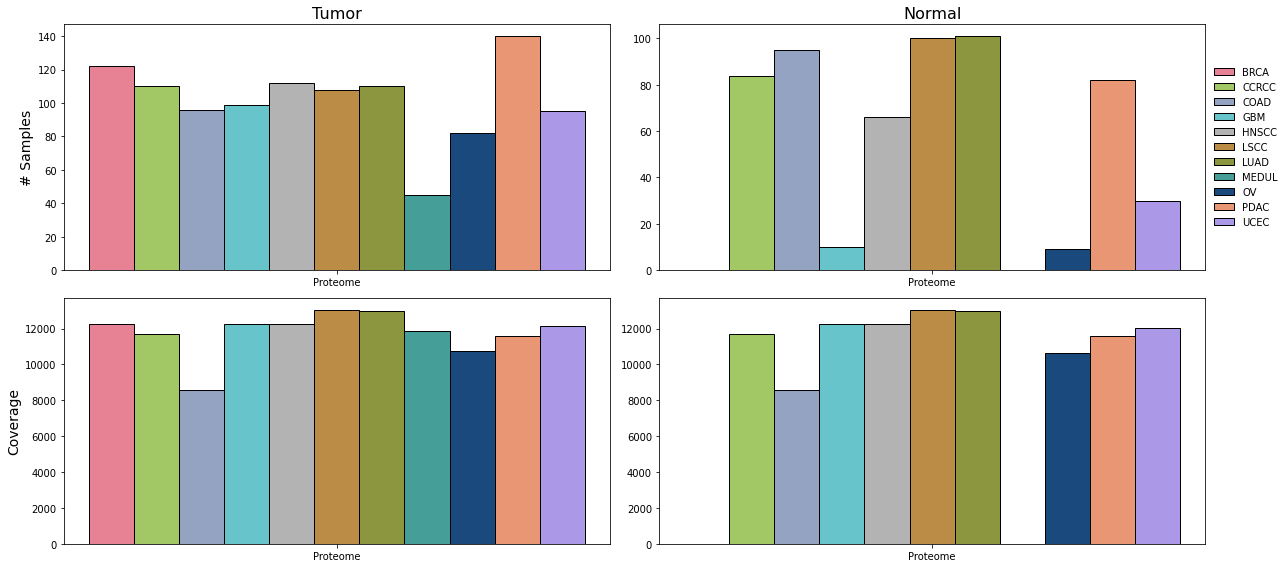

In [183]:
pl.plot_cohort_coverage(full_feats_df)
plt.savefig(os.path.join(PLOTS_DIR, "cohort_coverage_barplot.pdf"), dpi=100, bbox_inches='tight')

In [184]:
full_feats_df.to_csv(os.path.join(DATA_DIR, "proteome_ptm_n_samples_coverage.tsv"),sep='\t')

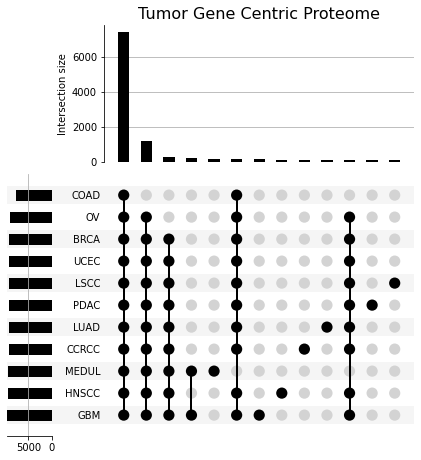

In [189]:
pl.plot_prot_upset(features_df, 'proteome','Tumor', min_features=100, title='Tumor Gene Centric Proteome')
plt.savefig(os.path.join(PLOTS_DIR, "tumor_proteome_upset.pdf"), dpi=100, bbox_inches='tight')

# pl.plot_prot_upset(features_df, 'phosphoproteome','Tumor', min_features=500, title='Tumor Phosphoproteome')
# plt.savefig(os.path.join(PLOTS_DIR, "tumor_phosphoproteome_upset.pdf"), dpi=100, bbox_inches='tight')

# pl.plot_prot_upset(features_df, 'acetylome','Tumor', min_features=100, title='Tumor Acetylome')
# plt.savefig(os.path.join(PLOTS_DIR, "tumor_acetylome_upset.pdf"), dpi=100, bbox_inches='tight')

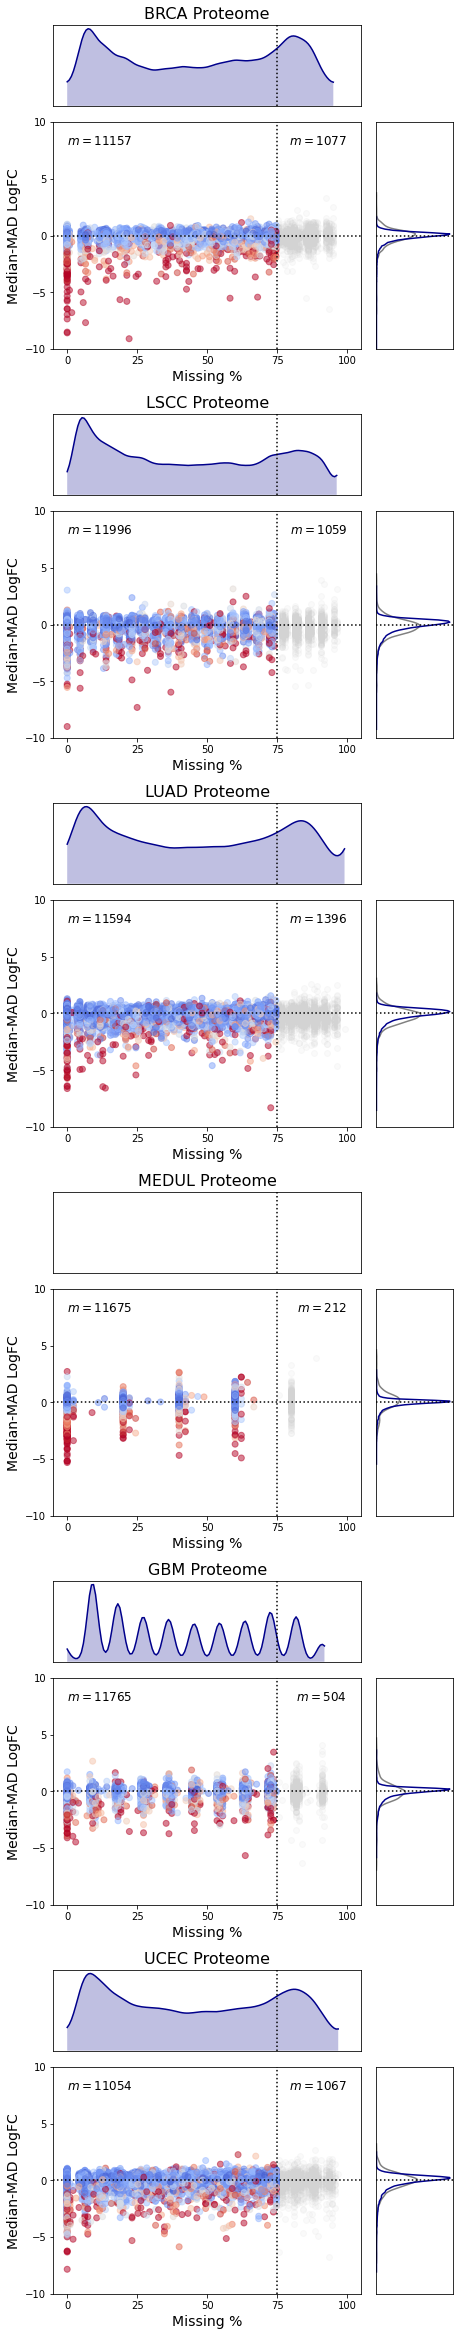

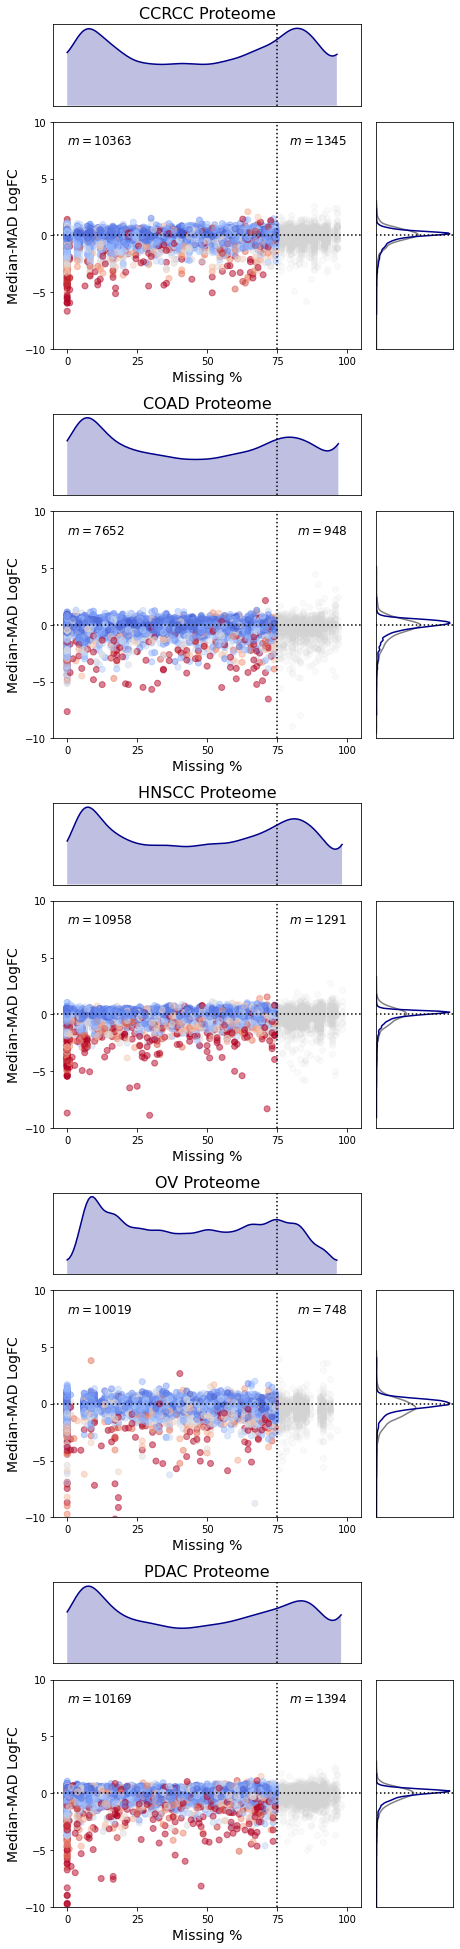

In [186]:
_aggr_1_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']),
    #['proteome','phosphoproteome','acetylome'],
    ['proteome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_1.pdf"), dpi=100, bbox_inches='tight')

_aggr_2_df = pl.plot_prot_grid_qc(
    raw_data_files,
    np.array(['CCRCC','COAD','HNSCC','OV','PDAC']),
    #['proteome','phosphoproteome'],
    ['proteome'],
    (0.75,0.75,0.75)
)
plt.savefig(os.path.join(PLOTS_DIR, "raw_tumor_grid_qc_2.pdf"), dpi=100, bbox_inches='tight')

In [187]:
_aggr_1_df += _aggr_2_df
aggr_df = pd.concat(_aggr_1_df)

In [188]:
intersecting_sites = {}

for assay in assays:
    gb = aggr_df[(aggr_df['assay']==assay) & (aggr_df['keep'])].reset_index().groupby('id').size()
    
    if assay=='acetylome':
        intersecting_sites[assay] = np.array(gb[gb==6].index)
    else:
        intersecting_sites[assay] = np.array(gb[gb==11].index)
        
    print("{} - {} intersecting sites".format(assay, intersecting_sites[assay].shape[0]))

proteome - 6648 intersecting sites


In [190]:
cohorts = np.unique(samples_df['cohort'])

In [191]:
X = {}

assay = 'proteome'
X[assay] = pd.concat(
    [
        raw_data_files[assay][cohort]['Tumor'] for
        cohort in 
        cohorts
    ],1
).T

# assay = 'phosphoproteome'
# X[assay] = pd.concat(
#     [
#         raw_data_files[assay][cohort]['Tumor'] for
#         cohort in 
#         cohorts
#     ],1
# ).T

# assay = 'acetylome'
# X[assay] = pd.concat(
#     [
#         raw_data_files[assay][cohort]['Tumor'] for
#         cohort in 
#         ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']
#     ],1
# ).T

In [192]:
print('--- Matrices ---')
pp.print_d(X)

# Save Raw-processed 
#X['acetylome'].T.to_csv(os.path.join(OUT_DIR, "raw", "acetylome_X.tsv.gz"), sep='\t')
X['proteome'].T.to_csv(os.path.join(OUT_DIR, "raw", "proteome_X.tsv.gz"), sep='\t')
#X['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "raw", "phosphoproteome_X.tsv.gz"), sep='\t')

--- Matrices ---
proteome: 1119 samples x 15699 features.


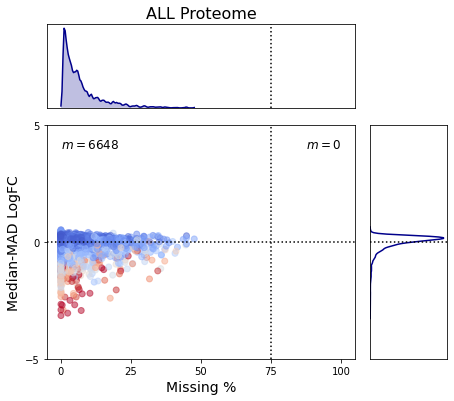

In [196]:
fig = plt.figure(figsize=(len(assays)*8,8))
gs = gridspec.GridSpec(9, 10*len(assays), hspace=0.5, wspace=0.5)

aggr_full_df = list()

lim=0.75

for col_idx,assay in enumerate(assays):
    idx = 0
    ax = plt.subplot(gs[(idx)*8+2:(idx+1)*8-1, 10*col_idx:(10*col_idx+7)])
    ax2 = plt.subplot(gs[(idx)*8+2:(idx+1)*8-1,(10*col_idx+7):(10*col_idx+9)])
    ax3 = plt.subplot(gs[(idx)*8:(idx)*8+2, 10*col_idx:(10*col_idx+7)])

    _aggr_df = pl.plot_prot_qc(
        X[assay].T.loc[intersecting_sites[assay]], 
        na_proportion_lim=lim, 
        title='ALL {}'.format(assay.capitalize()),
        axes=(ax,ax2,ax3),
        ylim=(-5,5)
        
    )
    ax.set_yticks([-5,0,5])
                
    _aggr_df['assay'] = assay
    aggr_full_df.append(_aggr_df)

aggr_full_df = pd.concat(aggr_full_df)
plt.savefig(os.path.join(PLOTS_DIR, "all_intersecting_grid_qc_plot.pdf"), dpi=100, bbox_inches='tight')

In [197]:
X_filt = dict()

X_filt['proteome'] = X['proteome'].loc[:,intersecting_sites['proteome']]
#X_filt['phosphoproteome'] = X['phosphoproteome'].loc[:,intersecting_sites['phosphoproteome']]
#X_filt['acetylome'] = X['acetylome'].loc[:,intersecting_sites['acetylome']]

In [198]:
print('--- Matrices ---')
pp.print_d(X_filt)

# Save na-filtered
#X_filt['acetylome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "acetylome_X.tsv.gz"), sep='\t')
X_filt['proteome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "proteome_X.tsv.gz"), sep='\t')
#X_filt['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "nafilt", "phosphoproteome_X.tsv.gz"), sep='\t')

--- Matrices ---
proteome: 1119 samples x 6648 features.


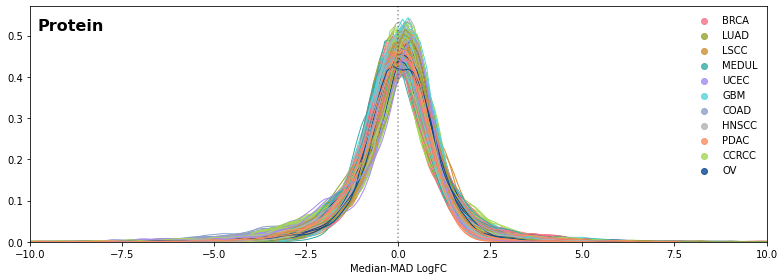

In [201]:
meta_s = samples_df[['cohort','Proteome_Sample_ID']].dropna().set_index("Proteome_Sample_ID")['cohort']

#fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True, sharey=True)
fig,ax = plt.subplots(figsize=(11,4), sharex=True, sharey=True)

pl.plot_sample_dist(X_filt['proteome'], meta_s, ax=ax, title='Protein')
#pl.plot_sample_dist(X_filt['phosphoproteome'], meta_s, ax=axes[1], title='Phosphorylation')
#pl.plot_sample_dist(X_filt['acetylome'], meta_s, ax=axes[2], title='Acetylation')

#axes[2].set_xlabel("Median-MAD LogFC")
ax.set_xlabel("Median-MAD LogFC")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_sample_dist.pdf"), dpi=300, bbox_inches='tight')

## 5. Impute within Each Dataset

---

In [202]:
from sklearn.impute import KNNImputer

X_filt_i = {}

for assay in X_filt.keys():
    X_filt_i[assay] = list()
    
    if assay=='acetylome':
        _cohorts = ['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC']
    else:
        _cohorts = cohorts
    
    for cohort in _cohorts:
        cohort_s = meta_s[meta_s==cohort].index
        
        # Fit Imputer
        imputer = KNNImputer(n_neighbors=KNN_NEIGHBORS)
        _X_i = pd.DataFrame(
            imputer.fit_transform(X_filt[assay].loc[cohort_s]), 
            index=cohort_s, 
            columns=X_filt[assay].columns
        )
        
        X_filt_i[assay].append(_X_i)
        
    X_filt_i[assay] = pd.concat(X_filt_i[assay])

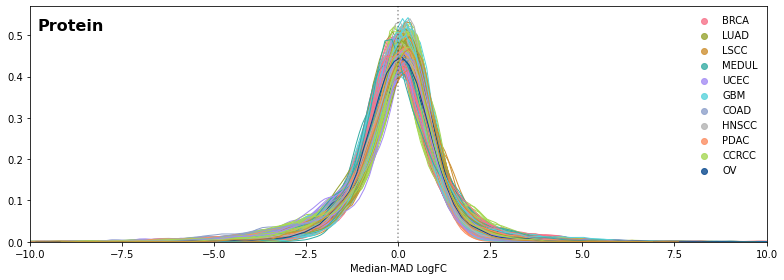

In [203]:
#fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True, sharey=True)
fig,ax = plt.subplots(figsize=(11,4), sharex=True, sharey=True)

pl.plot_sample_dist(X_filt_i['proteome'], meta_s, ax=ax, title='Protein')
#pl.plot_sample_dist(X_filt_i['phosphoproteome'], meta_s, ax=axes[1], title='Phosphorylation')
#pl.plot_sample_dist(X_filt_i['acetylome'], meta_s, ax=axes[2], title='Acetylation')

# axes[0].set_ylim(0,0.8)
# axes[1].set_ylim(0,0.8)
# axes[2].set_ylim(0,0.8)
ax.set_xlabel("Median-MAD LogFC")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_i_sample_dist.pdf"), dpi=300, bbox_inches='tight')

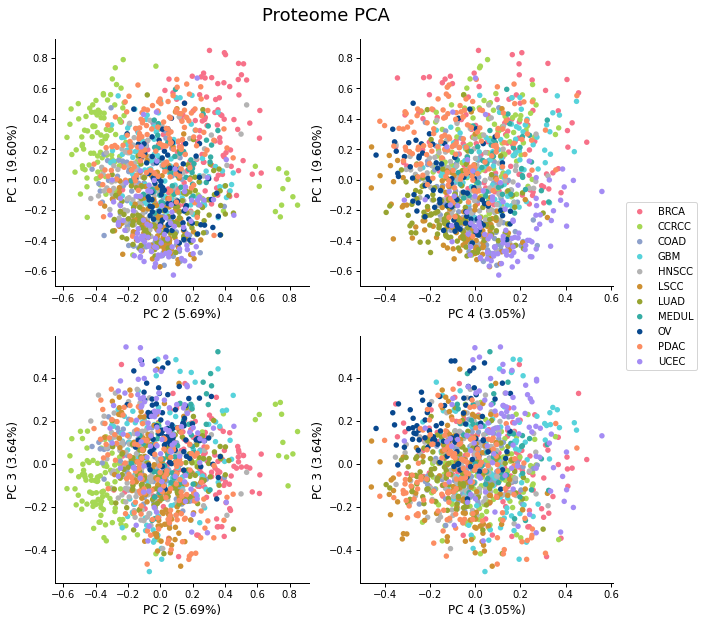

In [204]:
pl.plot_pca_grid(
    X_filt_i['proteome'].T, 
    normalize=False, 
    cohort_s=meta_s, 
    cohort_colors=pl.CPTAC_CMAP, 
    title='Proteome PCA'
)
plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_proteome_pca.pdf"), dpi=200, bbox_inches='tight')

In [205]:
# pl.plot_pca_grid(
#     X_filt_i['phosphoproteome'].T, 
#     normalize=False, 
#     cohort_s=meta_s, 
#     cohort_colors=pl.CPTAC_CMAP, 
#     title='Phosphoproteome PCA'
# )
# plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_phosphoproteome_pca.pdf"), dpi=200, bbox_inches='tight')

In [206]:
# pl.plot_pca_grid(
#     X_filt_i['acetylome'].T, 
#     normalize=False, 
#     cohort_s=meta_s, 
#     cohort_colors=pl.CPTAC_CMAP, 
#     title='Acetylome PCA'
# )
# plt.savefig(os.path.join(PLOTS_DIR, "x_filt_i_acetylome_pca.pdf"), dpi=200, bbox_inches='tight')

In [207]:
#X_filt_i['acetylome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "acetylome_X.tsv.gz"), sep='\t')
X_filt_i['proteome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "proteome_X.tsv.gz"), sep='\t')
#X_filt_i['phosphoproteome'].T.to_csv(os.path.join(OUT_DIR, "imputed", "phosphoproteome_X.tsv.gz"), sep='\t')

In [209]:
# print("  * {} acetylomics sites\n  * {} proteomics sites\n  * {} phosphorylation sites".format(
#     X_filt_i['acetylome'].shape[1],
#     X_filt_i['proteome'].shape[1],
#     X_filt_i['phosphoproteome'].shape[1]
# ))

## (NOT COMPLETE) 6. Normalize PTM by Protein Expression 

---

In [60]:
acetyl_samples = X_filt_i['acetylome'].index

In [61]:
df1,res1 = prot.fit_ptm_prot_ols(X_filt_i['phosphoproteome'].T, X_filt_i['proteome'].T, meta_s)
df2,res2 = prot.fit_ptm_prot_ols(X_filt_i['acetylome'].loc[acetyl_samples].T, X_filt_i['proteome'].loc[acetyl_samples].T, meta_s.loc[acetyl_samples])

Fitting OLS:   0%|          | 0/6 [00:00<?, ?it/s]

   * 3341 / 4992 sites with matching protein


Fitting OLS: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


   * 1889 / 2312 sites with matching protein


   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 1889 / 2312 sites with matching protein


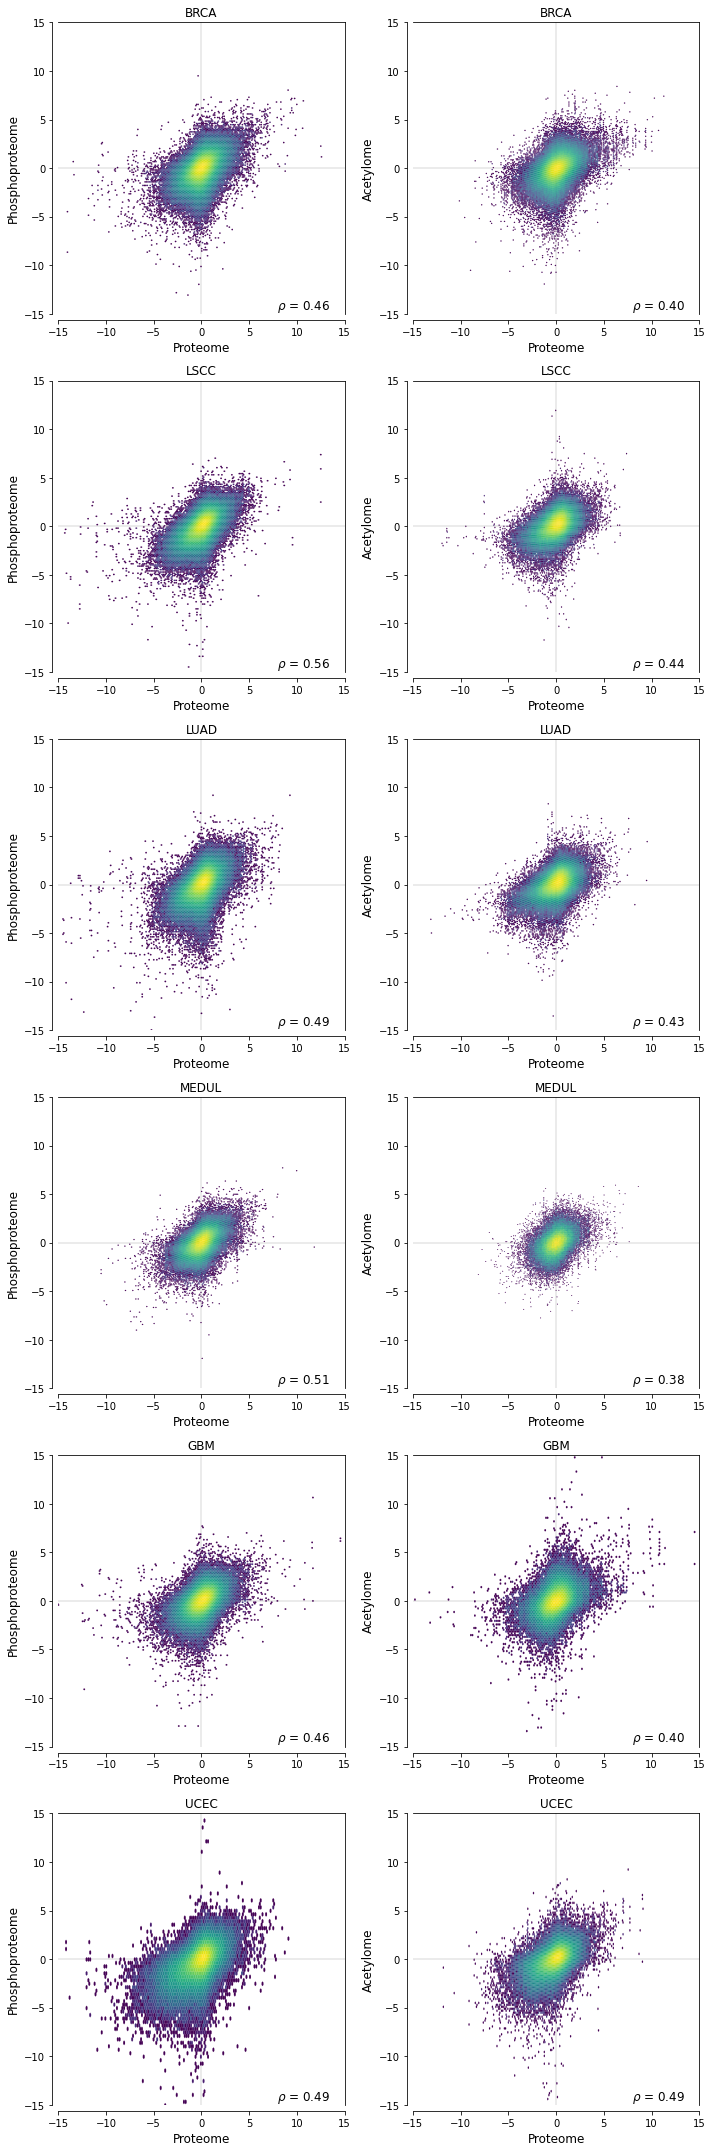

In [62]:
a_cohorts = np.array(['BRCA','LSCC','LUAD','MEDUL','GBM','UCEC'])

fig,axes = plt.subplots(6,2,figsize=(10,30))

for i,cohort in enumerate(a_cohorts):
    pl.plot_ptm_prot_ols(
        X_filt_i['phosphoproteome'].T, 
        X_filt_i['proteome'].T, 
        meta_s, 
        cohort, 
        ax=axes[i,0], 
        l=15,
        plot_density=True
    )
    
    axes[i,0].set_title(cohort)
    axes[i,0].set_ylabel('Phosphoproteome')
    axes[i,0].set_xlabel('Proteome')
    
    pl.plot_ptm_prot_ols(
        X_filt_i['acetylome'].loc[acetyl_samples].T, 
        X_filt_i['proteome'].loc[acetyl_samples].T, 
        meta_s.loc[acetyl_samples], 
        cohort, 
        ax=axes[i,1], 
        l=15,
        plot_density=True
    )
    axes[i,1].set_title(cohort)
    axes[i,1].set_ylabel('Acetylome')
    axes[i,1].set_xlabel('Proteome')
    
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,"cohort_prot_ptm_1_fit.pdf"), dpi=100, bbox_inches='tight')

   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein
   * 3341 / 4992 sites with matching protein


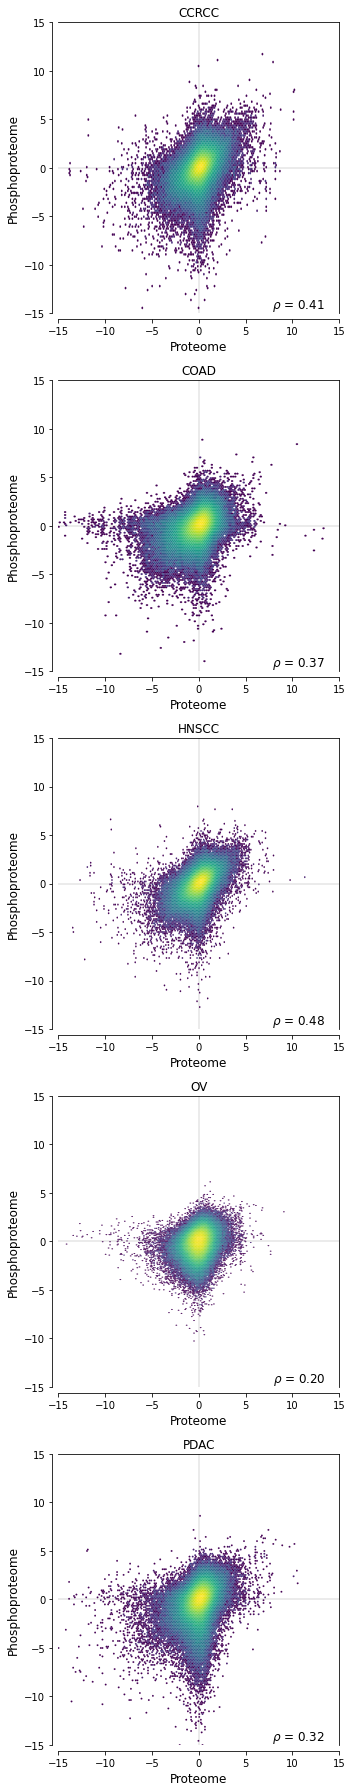

In [63]:
p_cohorts = np.array(['CCRCC','COAD','HNSCC','OV','PDAC'])

fig,axes = plt.subplots(5,1,figsize=(5,25))

for i,cohort in enumerate(p_cohorts):
    pl.plot_ptm_prot_ols(
        X_filt_i['phosphoproteome'].T, 
        X_filt_i['proteome'].T, 
        meta_s, 
        cohort, 
        ax=axes[i], 
        l=15,
        plot_density=True
    )
    
    axes[i].set_title(cohort)
    axes[i].set_ylabel('Phosphoproteome')
    axes[i].set_xlabel('Proteome')
    
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR,"cohort_prot_ptm_2_fit.pdf"), dpi=100, bbox_inches='tight')

In [64]:
df1.to_csv(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_ols_filt.tsv.gz"))
df2.to_csv(os.path.join(OUT_DIR, "imputed_res", "acetylome_ols_filt.tsv.gz"))

phosph_res = pd.pivot(df1.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')
acetyl_res = pd.pivot(df2.reset_index()[['id','sample','residual']], index='id',columns='sample',values='residual')

phosph_res.to_parquet(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_X.parquet"))
acetyl_res.to_parquet(os.path.join(OUT_DIR, "imputed_res", "acetylome_X.parquet"))
X_filt_i['proteome'].T.to_parquet(os.path.join(OUT_DIR, "imputed_res", "proteome_X.parquet"))

phosph_res.to_csv(os.path.join(OUT_DIR, "imputed_res", "phosphoproteome_X.tsv.gz"),sep='\t')
acetyl_res.to_csv(os.path.join(OUT_DIR, "imputed_res", "acetylome_X.tsv.gz"),sep='\t')
X_filt_i['proteome'].T.to_csv(os.path.join(OUT_DIR, "imputed_res", "proteome_X.tsv.gz"),sep='\t')

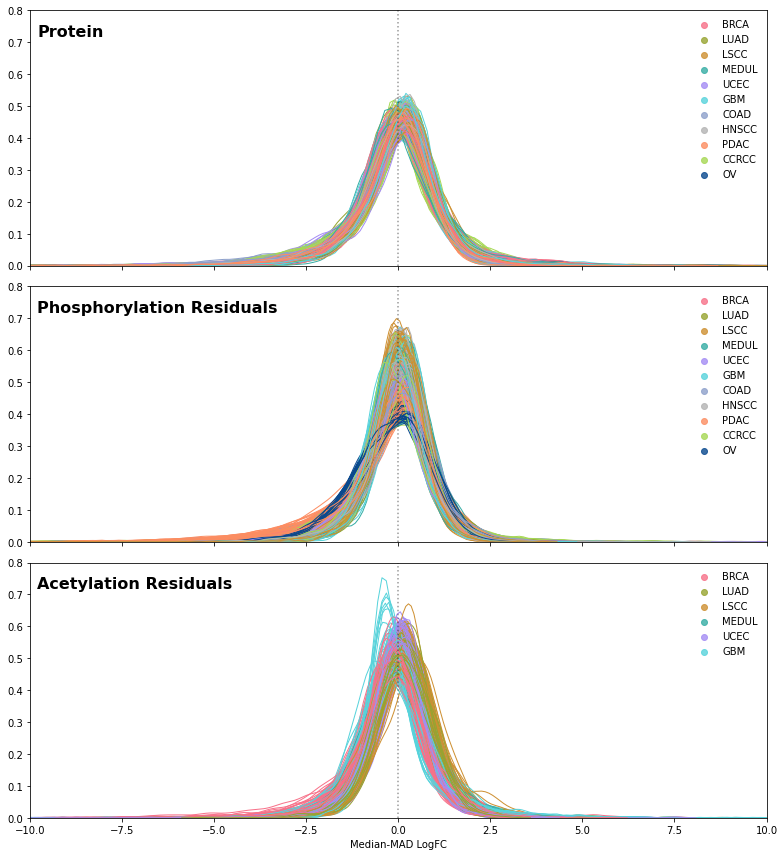

In [65]:
fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True)

pl.plot_sample_dist(X_filt_i['proteome'], meta_s, ax=axes[0], title='Protein')
pl.plot_sample_dist(phosph_res.T, meta_s, ax=axes[1], title='Phosphorylation Residuals')
pl.plot_sample_dist(acetyl_res.T, meta_s, ax=axes[2], title='Acetylation Residuals')

axes[0].set_ylim(0,0.8)
axes[1].set_ylim(0,0.8)
axes[2].set_ylim(0,0.8)
axes[2].set_xlabel("Median-MAD LogFC")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_filt_i_res_sample_dist.pdf"), dpi=300, bbox_inches='tight')